# Geologic profiles

*Doc started 2019-05-12*

*Current version: 2019-07-29*

This notebook describes the calculation of topographic profiles. As input data we need a DEM and a profile.

The geometric class used from *pygsf* are:
- *Line*: a collection of *Points*.
- *MultiLine*: a collection of Lines.
- *GeoArray*: a collection of one or more georeferenced grids (in our case we use a *GeoArray* containing a single grid). 

Figures are plotted via matplotlib:

In [1]:
%matplotlib inline

Data sets can be plotted with pprint:

In [2]:
from pprint import pprint

## 1-  Mount Alpi (Lucania, Southern Italy)

### DEM input

The source DEM derives from publicly available Aster data and refers to the the Mt. Alpi zone (Lucania, Southern Italy):

In [3]:
source_data = "/home/mauro/Documents/projects/geoprocess/example_data/mt_alpi/malpi_aster_w4u3.tif"

We read the DEM using a wrapper function to GDAL:

In [4]:
from geoprocess.rasters.io import read_raster_band
geoarray = read_raster_band(raster_source=source_data, epsg_cd = 32633)
geoarray

GeoArray with 1 band(s) - CRS: EPSG: 32633

Band 1: 260 rows x 213 cols; min: 0.0,  max: 1829.0

The DEM projection is UTM zone 33 N. We plot it.

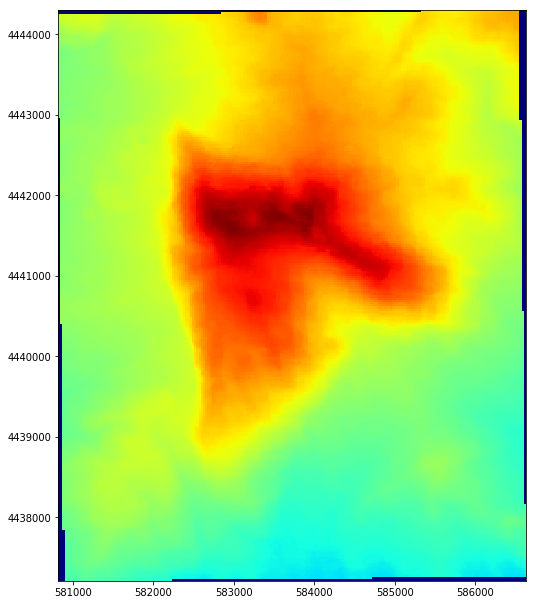

In [5]:
from geoprocess.maps.plot import plot_grid
fig = plot_grid(geoarray)

### Source profile

Now we read the source profile from a line shapefile. It is a single line, projected in WGS 84 - UTM 33 N.

In [6]:
src_profile_shapefile_pth = "/home/mauro/Documents/projects/geoprocess/example_data/mt_alpi/profile.shp"

In [7]:
from geoprocess.vectorial.io import read_linestring_geometries
profiles = read_linestring_geometries(src_profile_shapefile_pth)
print(profiles)

MultiLine with 1 line(s) and 2 total point(s) - EPSG: 32633


This *MultiLine* instance contains a single line, that is made up by two points.
The spatial reference of the line profile is the same as the raster DEM: WGS1984 - UTM 33 N. 
So no projection conversion is required to calculate the profile.

Now we extract the profile line and add it in the previous map.

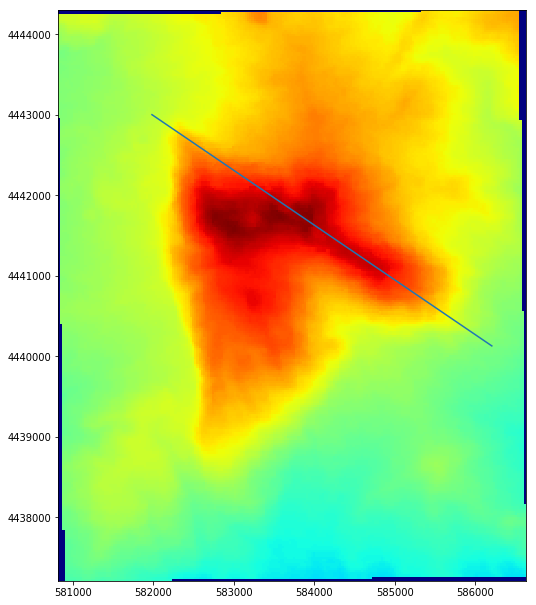

In [8]:
line = profiles.extract_line()
from geoprocess.maps.plot import plot_line
plot_line(fig, line)

### Initializing a geoprofile

The *geoprofile* is the unitary container for our topographic and geological data related to a single geological profiles. It is initialized as an empty geoprofile, to which content will be added in subsequent steps.

In [9]:
from geoprocess.profiles.geoprofiles import GeoProfile
geoprofile = GeoProfile()

### Creating a linear profiler

To extract the topographic and geologic elements from the various data source, we make use of the *linear profiler*.
The data extracted will then be added to the *geoprofile*. 

We generate a *linear profiler*, with a spacing of 5 meters along the profile, by making use of the *LinearProfiler* class in the *geoprocess* module.

In [10]:
from geoprocess.profiles.profilers import LinearProfiler
profiler = LinearProfiler(start_pt=line.start_pt(), end_pt=line.end_pt(), densify_distance= 5)

In [11]:
profiler

LinearProfiler(
	start_pt = Point(581981.1880, 4442999.2144, 0.0000, 0.0000, 32633),
	end_pt = Point(586203.5723, 4440126.1905, 0.0000, 0.0000, 32633),
	densify_distance = 5.0)

In [12]:
profiler.num_pts()

1023

The number of points making up the profile is slightly more than a thousand.

### Adding a topographic profile

Now we create and plot a vertical topographic profile using as elevation data source the previously defined DEM. 

In [13]:
topo_profile = profiler.profile_grid(geoarray)
print("Type of 'topo_profile': {}".format(type(topo_profile)))

Type of 'topo_profile': <class 'geoprocess.profiles.chains.TopographicProfile'>


The variable *topo_profile* is an instance of <*geoprocess.profiles.base.ScalarProfiles*>. 
The *Scalar* prefix to *Profiles* means that scalar values (f.i., elevations) are stored in the profile(s).

Since we used just one grid as a parameter for the *profile_grids* method, there is a single topographic profile stored in the variable.

Now we add the topographic profile to the geological profile:

In [14]:
geoprofile.topo_profile = topo_profile

And then plot it:

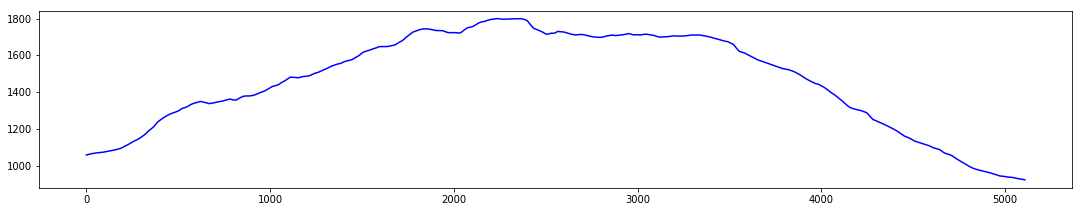

In [15]:
geoprofile.plot()

### Geological attitudes plot

We extract geological attitudes from a shapefile:

In [16]:
attitudes_shape = "/home/mauro/Documents/projects/geoprocess/example_data/mt_alpi/attitudes.shp"

We use the *geopandas* module to read the data. It will create a *geopandas.GeoDataFrame* instance.

In [17]:
import geopandas
attitudes = geopandas.read_file(attitudes_shape)
attitudes

,Id,dip_dir,dip_ang,Formation,type,geometry
0,1,90.0,18.0,Mesozoic limestones,stratification,POINT (583531.3752990747 4441614.400527005)
1,2,95.0,30.0,Miocenic conglomerates,stratification,POINT (583771.7042101115 4441895.090107)
2,3,72.0,26.0,Miocenic calcarenites,stratification,POINT (584184.3662285224 4441269.219572696)
3,4,75.0,40.0,Mesozoic limestones,stratification,POINT (584722.1560370894 4441071.520369892)
4,5,80.0,15.0,Mesozoic limestones,stratification,POINT (582878.6868614436 4442105.862605924)
5,6,60.0,25.0,Miocenic calcarenites,stratification,POINT (584266.8487914705 4441208.758074153)
6,7,30.0,15.0,Mesozoic limestones,stratification,POINT (584249.6835671976 4441182.483860023)
7,8,70.0,35.0,Mesozoic limestones,stratification,POINT (584838.6306295315 4440925.73280247)
8,9,105.0,40.0,Mesozoic limestones,stratification,POINT (584644.0964890748 4441353.933542896)
9,10,135.0,21.0,Miocenic arenites and conglomerates,stratification,POINT (585641.1138067038 4440448.176409098)


In [18]:
attitudes.crs

{'init': 'epsg:32633'}

The projection of the source dataset is UTM33, as are the DEM and the profile, so we do need any reprojection.

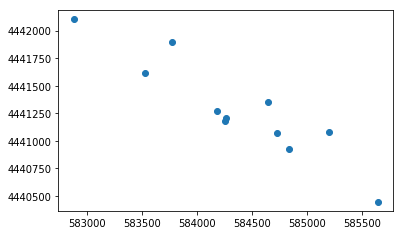

In [19]:
ax = attitudes.plot()

We get the relevant infos from the geodataframe. We do not provide any name for the id field name in the *extract_georeferenced_attitudes* function, so the id will be simple a progressive counter. Otherwise the id would be red by the provided field name.

In [20]:
from geoprocess.geology.convert import extract_georeferenced_attitudes
attitudes = extract_georeferenced_attitudes(
    geodataframe = attitudes, 
    dip_dir_fldnm = "dip_dir", 
    dip_ang_fldnm = "dip_ang")

In [21]:
print("Number of attitudes: {}".format(len(attitudes)))

Number of attitudes: 11


In [22]:
pprint(attitudes)

[GeorefAttitude(id=1, posit=Point(583531.3753, 4441614.4005, 0.0000, 0.0000, 32633), attitude=Plane(090.00, +18.00)),
 GeorefAttitude(id=2, posit=Point(583771.7042, 4441895.0901, 0.0000, 0.0000, 32633), attitude=Plane(095.00, +30.00)),
 GeorefAttitude(id=3, posit=Point(584184.3662, 4441269.2196, 0.0000, 0.0000, 32633), attitude=Plane(072.00, +26.00)),
 GeorefAttitude(id=4, posit=Point(584722.1560, 4441071.5204, 0.0000, 0.0000, 32633), attitude=Plane(075.00, +40.00)),
 GeorefAttitude(id=5, posit=Point(582878.6869, 4442105.8626, 0.0000, 0.0000, 32633), attitude=Plane(080.00, +15.00)),
 GeorefAttitude(id=6, posit=Point(584266.8488, 4441208.7581, 0.0000, 0.0000, 32633), attitude=Plane(060.00, +25.00)),
 GeorefAttitude(id=7, posit=Point(584249.6836, 4441182.4839, 0.0000, 0.0000, 32633), attitude=Plane(030.00, +15.00)),
 GeorefAttitude(id=8, posit=Point(584838.6306, 4440925.7328, 0.0000, 0.0000, 32633), attitude=Plane(070.00, +35.00)),
 GeorefAttitude(id=9, posit=Point(584644.0965, 4441353.9

A georeferenced attitude is defined by its *id*, *postion* and *attitude*. We note that the points are 2D, since their elevation value, i.e., their third Cartesian coordinate, is always zero (the fourth coordinate is time and the last is the EPSG numeric code). Their elevation will be automatically extracted from the DEM in the following steps by choosing a *height_source* parameter in the *map_georef_attitudes_to_section* method.

Having converted the data in a suitable format (i.e., *GeorefAttitude*), now we calculate the projections of the attitude on the section:

In [23]:
mapping_method = {}
mapping_method['method'] = 'nearest'
att_projs = profiler.map_georef_attitudes_to_section(
            structural_data = attitudes,
            mapping_method = mapping_method,
            height_source = geoarray) 

In [24]:
pprint(att_projs)

[ProfileAttitude(id=5, s=1236.4861872424606, z=1572.5213765137596, slope_degr=10.867965575312148, down_sense=right, dist=237.6050261383221),
 ProfileAttitude(id=1, s=2048.1696666709017, z=1719.0523705180385, slope_degr=15.036461412285021, down_sense=right, dist=277.07059293755856),
 ProfileAttitude(id=2, s=2112.1540235549446, z=1778.1549344889354, slope_degr=26.739985134228576, down_sense=right, dist=97.35582649748838),
 ProfileAttitude(id=3, s=2774.5313396243873, z=1565.4636538076447, slope_degr=16.631758453194006, down_sense=right, dist=203.50319812472765),
 ProfileAttitude(id=6, s=2881.0196828011162, z=1557.8591956259916, slope_degr=11.459372574286705, down_sense=right, dist=210.30767756509084),
 ProfileAttitude(id=7, s=2898.7039708295083, z=1533.092653978907, slope_degr=1.1328961144174967, down_sense=left, dist=233.78088130040757),
 ProfileAttitude(id=9, s=3145.682021481595, z=1650.3363548688358, slope_degr=38.388714168301426, down_sense=right, dist=140.9625488932911),
 ProfileAtti

Resulting profile attitudes are automatically sorted by their increasing distance along the profile. The main fields are:
- *id*: identifier inherited from the georeferenced attitudes, 
- *s*: the distance of the projected attitude along the profile (may be negative or exceeed the profile length),  
- *z*: the elevation, 
- *slope_degr*: the resulting slope, in degrees, 
- *down_sense*: describes whether the plane plunges to the right or to the left, 
- *dist*: the distance between the original attitude location and its projection (according to the chosen method) on the profile plane.

In [25]:
geoprofile.attitudes = att_projs

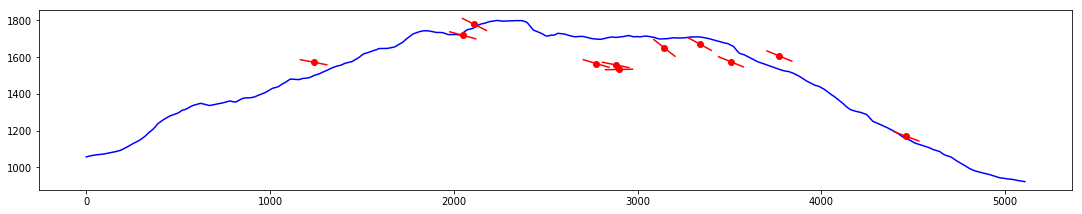

In [26]:
geoprofile.plot()

## 2 - Timpa San Lorenzo area (Calabria, Southern Italy)

Now we move around 35 km to the South-East of the Mt. Alpi are, and consider the Timpa San Lorenzo area, in Calabria, East of Mt. Pollino range.

Source data are a TinItaly DEM, in addition to a base profile.

In [27]:
src_dem = "/home/mauro/Documents/projects/geoprocess/example_data/timpa_san_lorenzo/tsl_tinitaly_w84u32.tif"
src_profile = "/home/mauro/Documents/projects/geoprocess/example_data/timpa_san_lorenzo/profile.shp"

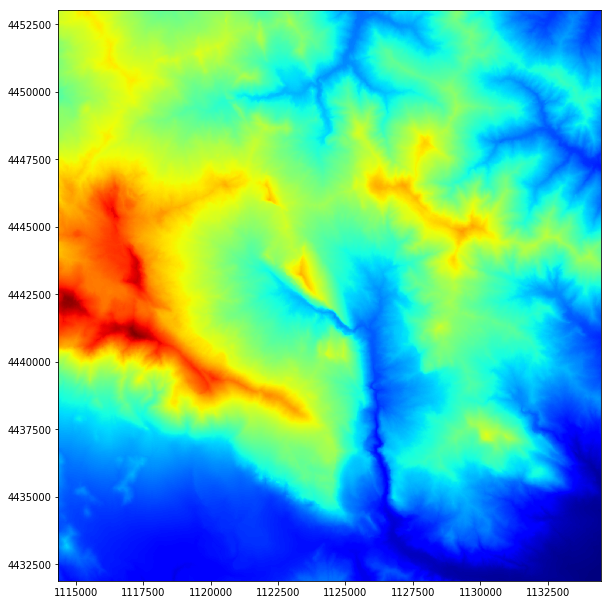

In [28]:
geoarray = read_raster_band(raster_source=src_dem, epsg_cd = 32632)
fig = plot_grid(geoarray)

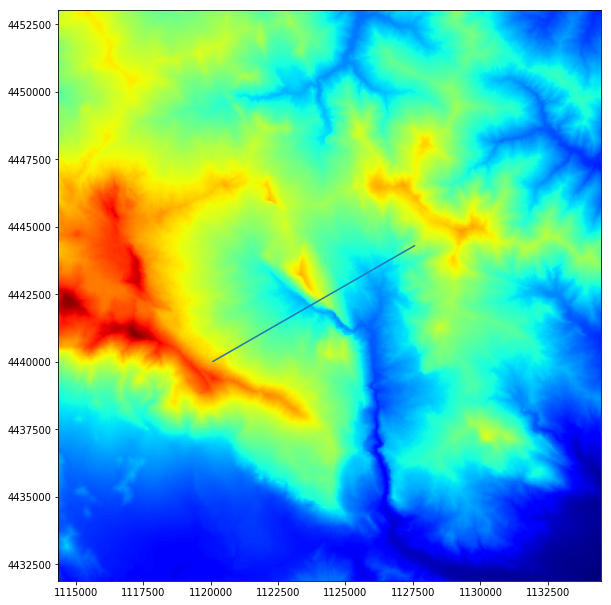

In [29]:
profiles = read_linestring_geometries(src_profile)
line = profiles.extract_line()
plot_line(fig, line)

In [30]:
from geoprocess.profiles.geoprofiles import GeoProfileSet
geoprofiles = GeoProfileSet()
base_profiler = LinearProfiler(
    start_pt=line.start_pt(), 
    end_pt=line.end_pt(), 
    densify_distance= 5
)

In [31]:
base_profiler

LinearProfiler(
	start_pt = Point(1127556.9338, 4444295.7371, 0.0000, 0.0000, 32632),
	end_pt = Point(1120091.0876, 4440008.7082, 0.0000, 0.0000, 32632),
	densify_distance = 5.0)

In [32]:
base_profiler.num_pts()

1723

In [33]:
from geoprocess.profiles.profilers import ParallelProfilers
multiple_profilers = ParallelProfilers.fromProfiler(
             base_profiler=base_profiler,
             profs_num=3,
             profs_offset=4000,
             profs_arr="central")

In [34]:
multiple_profilers

ParallelProfilers([
LinearProfiler(
	start_pt = Point(1129548.7814, 4440826.9414, 0.0000, 0.0000, 32632),
	end_pt = Point(1122082.9351, 4436539.9125, 0.0000, 0.0000, 32632),
	densify_distance = 5.0)
LinearProfiler(
	start_pt = Point(1127556.9338, 4444295.7371, 0.0000, 0.0000, 32632),
	end_pt = Point(1120091.0876, 4440008.7082, 0.0000, 0.0000, 32632),
	densify_distance = 5.0)
LinearProfiler(
	start_pt = Point(1125565.0863, 4447764.5328, 0.0000, 0.0000, 32632),
	end_pt = Point(1118099.2400, 4443477.5038, 0.0000, 0.0000, 32632),
	densify_distance = 5.0)]
)

In [35]:
topo_profiles = multiple_profilers.profile_grid(geoarray)

In [36]:
print(topo_profiles)

[<geoprocess.profiles.chains.TopographicProfile object at 0x7fa155f44438>, <geoprocess.profiles.chains.TopographicProfile object at 0x7fa1480db470>, <geoprocess.profiles.chains.TopographicProfile object at 0x7fa155f8f400>]


In [ ]:
for topo_profile in topo_profiles:
    

### Line intersections